In [14]:
import json
import os
import re
import pandas as pd

# Directory with JSON files
input_dir = "../output"

models = [
    "meta-llama/Llama-2-7b-hf",
    # "meta-llama/Llama-2-7b-chat-hf",
    # "mistralai/Mistral-7B-v0.3",
    "cygu/llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta2",
    "cygu/llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta1",
    "cygu/llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta1.5",
    "cygu/llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta1.25",

    # "meta-llama/Llama-3.1-8B-Instruct",
    # "meta-llama/Llama-3.1-8B"
]

file_dirs = {
    "new": "../output/mb",
    "base": "../output",
}


output_csv = os.path.join(input_dir, "metrics.csv")

filename_pattern = re.compile(
    r"output_.*?"
    r"(?:align=(\d+))?[^a-zA-Z0-9]*"
    r"(?:dataset=([a-zA-Z0-9_\-]+))?[^a-zA-Z0-9]*"
    r"\.json$"
)
rows = []


def parse_row(json_file):
    with open(json_file, "r") as f:
        data = json.load(f)
        watermark = data["watermark"]
        config = data["config"]
        n_clusters = config.get("n_clusters", 0)

       
        if watermark == "gaussmark":
            config_id = f"watermark=gaussmark_sigma={config['sigma']}_param={config['target_param_name']}"
        elif watermark == "mb":
            config_id = f"watermark=mb_gamma={config['gamma']}_delta={config['delta']}_nclusters={n_clusters}"
        elif watermark == "mb2":
            return None  # Skip rows with mb2 watermark
            config_id = f"watermark=mb2_delta={config['delta']}"
        elif watermark == "mb3":
            return None
            config_id = f"watermark=mb3_delta={config['delta']}"
        elif watermark == "noise":
            return None
        elif watermark == "distilled":
            config_id = f"watermark=distilled"
        elif watermark == "kgw":
            config_id = f"watermark=kgw_gamma={config['gamma']}_delta={config['delta']}"
        elif watermark == "kgw_llr":
            config_id = f"watermark=kgw_llr_gamma={config['gamma']}_delta={config['delta']}"

        metrics = data["metrics"]
        metrics_60 = data.get("metrics_dipper_text_lex60_order0", {})
        metrics_20 = data.get("metrics_dipper_text_lex20_order0", {})
        ppl = data["ppl"]

        # Check if n_clusters approximately equal to the nearest power of 2 number
        if n_clusters > 32:
            # Check if n_clusters is a power of 2
            if (n_clusters & (n_clusters - 1)) == 0:
                # n_clusters is a power of 2, no adjustment needed
                pass
            else:
                nearest_power_of_2 = 1 << (n_clusters - 1).bit_length()
                if abs(n_clusters - nearest_power_of_2) <= 6:
                    n_clusters = nearest_power_of_2

        # if watermark == "noise":
        #     config_id = f"watermark=noise_delta={config['delta']}_distribution={config['distribution']}"
        # else:
        #     return None  # Skip rows with unsupported watermark types

        row = {
            "config_id": config_id,
            # "distribution": config.get("distribution"),
            "delta": config.get("delta"),
            "gamma": config.get("gamma"),
            "dataset": dataset,
            "n_clusters": config.get("n_clusters"),
            "target_param_name": config.get("target_param_name"),
            "auroc": metrics.get("auroc"),
            "best_f1_score": metrics.get("best_f1_score"),
            "tpr_1_fpr": metrics["tpr_1_fpr"],
            "tpr_0.1_fpr": metrics["tpr_0.1_fpr"],
            "auroc_lex60": metrics_60.get("auroc"),
            "f1_lex60": metrics_60.get("best_f1_score"),
            "tpr1_lex60": metrics_60.get("tpr_1_fpr"),
            "auroc_lex20": metrics_20.get("auroc"),
            "f1_lex20": metrics_20.get("best_f1_score"),
            "tpr1_lex20": metrics_20.get("tpr_1_fpr"),
            "ppl_mean": ppl["mean"],
            "ppl_median": ppl.get("median"),
            "mean_seq_rep_3": data.get("mean_seq_rep_3"),
            "model": model_suffix,
            "best_threshold": metrics.get("best_threshold"),
            "threshold_at_1_fpr": metrics.get("threshold_at_1_fpr"),
            "sigma": config.get("sigma"),
        }
        return row


for version, dir_path in file_dirs.items():
    for model in models:
        model_suffix = model.split("/")[-1]
        model_dir = os.path.join(dir_path, model_suffix)
        if not os.path.exists(model_dir):
            print(f"Directory does not exist: {model_dir}")
            continue
        json_files = [f for f in os.listdir(model_dir) if f.endswith(".json")]
        for json_file in json_files:
            match = filename_pattern.match(json_file)
            if not match:
                continue

            dataset = match.group(2) if match.group(2) is not None else None
            filepath = os.path.join(model_dir, json_file)
            try:
                row = parse_row(filepath)
                if row is not None:
                    row["version"] = version
                    rows.append(row)
            except Exception as e:
                print(f"Error processing {filepath}: {e}")

# Convert to DataFrame
df = pd.DataFrame(rows)

print(df["gamma"].unique())


# # Group by config_id and average all metric columns
grouped_df = df.groupby(["config_id", "dataset", "model", "version"]).mean(
    numeric_only=True).reset_index()

# Write to CSV
grouped_df.to_csv(output_csv, index=False)
print(f"Saved grouped averages to: {output_csv}")

Error processing ../output/mb/Llama-2-7b-hf/output_align=0_delta=1.0_gamma=0.3_k=235_seed=22983996_watermark=mb_dataset=realnewslike.json: 'ppl'
Error processing ../output/mb/Llama-2-7b-hf/output_seed=15485863_sigma=0.4_watermark=gaussmark_dataset=realnewslike.json: 'metrics'
Error processing ../output/mb/Llama-2-7b-hf/output_align=0_delta=1.0_gamma=0.3_k=235_seed=22983996_watermark=mb_dataset=booksum.json: 'ppl'
Error processing ../output/mb/Llama-2-7b-hf/output_align=0_delta=1.0_gamma=0.3_k=235_seed=15485863_watermark=mb_dataset=arxiv.json: 'ppl'
Error processing ../output/mb/Llama-2-7b-hf/output_align=0_delta=1.0_gamma=0.3_k=235_seed=15485863_watermark=mb_dataset=wikipedia.json: 'ppl'
Error processing ../output/mb/Llama-2-7b-hf/output_align=0_delta=1.0_gamma=0.3_k=235_seed=15485863_watermark=mb_dataset=realnewslike.json: 'ppl'
Error processing ../output/mb/Llama-2-7b-hf/output_align=0_delta=1.0_gamma=0.3_k=235_seed=12997009_watermark=mb_dataset=booksum.json: 'ppl'
Error processing .

In [15]:
import numpy as np
data = grouped_df
# Filter out rows with ppl_mean greater than 20
data = data[data["ppl_mean"] <= 16]
data = data[data["tpr_1_fpr"] >= 0.4]  # Use tpr_0.1_fpr for filtering
# Filter dataset by realnewslike

data = data[data["dataset"] == "realnewslike"]

gaussmark_data= data[data["config_id"].str.contains("watermark=gaussmark")]
gaussmark_w1 = gaussmark_data[~gaussmark_data["config_id"].str.contains("lm_head")]
gaussmark_w2 = gaussmark_data[gaussmark_data["config_id"].str.contains("lm_head")]

mb_data = data[data["config_id"].str.contains("watermark=mb") & (data["n_clusters"] == 235)]
# Filter by gamma values
mb_data_g1 = mb_data[np.isclose(mb_data["gamma"], 0.0)]
mb_data_g3 = mb_data[np.isclose(mb_data["gamma"], 0.25)]
mb_data_g5 = mb_data[np.isclose(mb_data["gamma"], 0.0)]
mb_data_g7 = mb_data[np.isclose(mb_data["gamma"], 0.0)]

kgw_data = data[data["config_id"].str.contains("watermark=kgw")]

kgw_llr_data = data[data["config_id"].str.contains("watermark=kgw_llr")]

distilled_data = data[data["config_id"].str.contains("watermark=distilled")]

# Print size of each DataFrame
print(f"KGW Data Size: {kgw_data.shape[0]}")
print(f"Gaussmark (layers.27.mlp.up_proj) Data Size: {gaussmark_w1.shape[0]}")
print(f"Gaussmark (lm_head) Data Size: {gaussmark_w2.shape[0]}")
print(f"Openstamp Data Size (gamma=0.1): {mb_data_g1.shape[0]}")
print(f"Openstamp Data Size (gamma=0.3): {mb_data_g3.shape[0]}")
print(f"Openstamp Data Size (gamma=0.5): {mb_data_g5.shape[0]}")
print(f"Openstamp Data Size (gamma=0.7): {mb_data_g7.shape[0]}")
print(f"Distilled Data Size: {distilled_data.shape[0]}")

KGW Data Size: 19
Gaussmark (layers.27.mlp.up_proj) Data Size: 4
Gaussmark (lm_head) Data Size: 6
Openstamp Data Size (gamma=0.1): 0
Openstamp Data Size (gamma=0.3): 8
Openstamp Data Size (gamma=0.5): 0
Openstamp Data Size (gamma=0.7): 0
Distilled Data Size: 4


In [17]:
# Sort gaussmark_w1 by tpr_1_fpr
gaussmark_w1 = gaussmark_w1.sort_values(by="tpr_1_fpr", ascending=False)
gaussmark_w2 = gaussmark_w2.sort_values(by="tpr_1_fpr", ascending=False)

print("Gaussmark (lm_head) Data Sample:")
gaussmark_w2[["config_id", "tpr_1_fpr", "tpr1_lex20", "tpr1_lex60", "ppl_mean"]]

Gaussmark (lm_head) Data Sample:


,config_id,tpr_1_fpr,tpr1_lex20,tpr1_lex60,ppl_mean
17,watermark=gaussmark_sigma=0.007_param=lm_head....,1.000000,NaN,NaN,15.889448
16,watermark=gaussmark_sigma=0.006_param=lm_head....,0.998667,0.787333,0.301333,14.703719
15,watermark=gaussmark_sigma=0.005_param=lm_head....,0.994000,NaN,NaN,14.052938
14,watermark=gaussmark_sigma=0.004_param=lm_head....,0.942667,NaN,NaN,13.178760
13,watermark=gaussmark_sigma=0.003_param=lm_head....,0.771333,NaN,NaN,12.582375
12,watermark=gaussmark_sigma=0.002_param=lm_head....,0.407333,NaN,NaN,12.515687


In [25]:
gaussmark_w1[["config_id", "auroc", "tpr_1_fpr", "auroc_lex20", "tpr1_lex20", "auroc_lex60", "tpr1_lex60", "ppl_mean"]]

,config_id,auroc,tpr_1_fpr,auroc_lex20,tpr1_lex20,auroc_lex60,tpr1_lex60,ppl_mean
23,watermark=gaussmark_sigma=0.04_param=model.lay...,0.990924,0.856000,0.958793,0.633333,0.919679,0.47,15.781542
20,watermark=gaussmark_sigma=0.035_param=model.la...,0.983849,0.793333,NaN,NaN,NaN,NaN,14.444151
21,watermark=gaussmark_sigma=0.03_param=model.lay...,0.971047,0.685333,NaN,NaN,NaN,NaN,13.645495
18,watermark=gaussmark_sigma=0.025_param=model.la...,0.950747,0.550000,NaN,NaN,NaN,NaN,13.309521


/tmp/ipykernel_1212263/3781753018.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kgw_data["label"] = "KGW + Binomial Test"
/tmp/ipykernel_1212263/3781753018.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kgw_llr_data["label"] = "KGW + LLR"
/tmp/ipykernel_1212263/3781753018.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

Gaussmark Configs:
['watermark=gaussmark_sigma=0.04_param=model.layers.27.mlp.up_proj.weight'
 'watermark=gaussmark_sigma=0.035_param=model.layers.27.mlp.up_proj.weight'
 'watermark=gaussmark_sigma=0.03_param=model.layers.27.mlp.up_proj.weight'
 'watermark=gaussmark_sigma=0.025_param=model.layers.27.mlp.up_proj.weight']
Gaussmark (lm_head) Configs:
['watermark=gaussmark_sigma=0.007_param=lm_head.weight'
 'watermark=gaussmark_sigma=0.006_param=lm_head.weight'
 'watermark=gaussmark_sigma=0.005_param=lm_head.weight'
 'watermark=gaussmark_sigma=0.004_param=lm_head.weight'
 'watermark=gaussmark_sigma=0.003_param=lm_head.weight'
 'watermark=gaussmark_sigma=0.002_param=lm_head.weight']


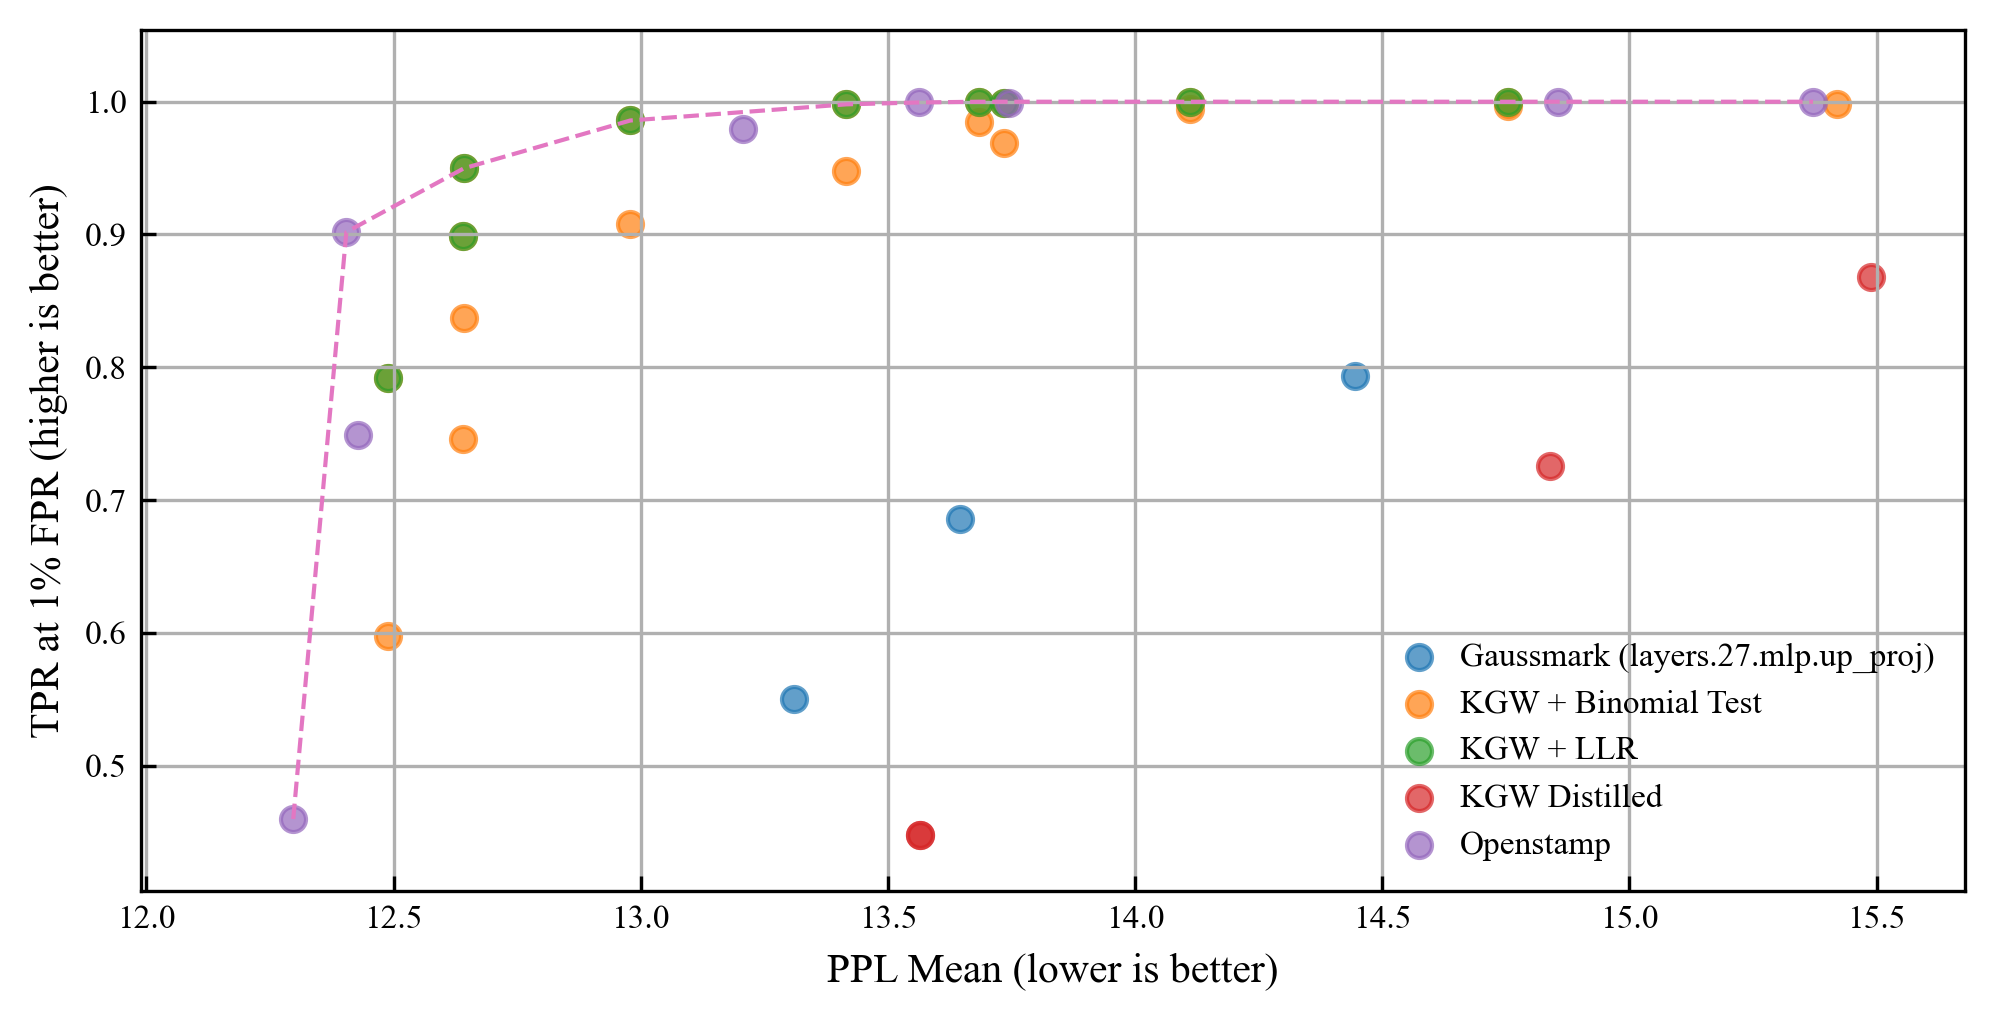

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.cm as cm

plt.style.use("aaai.mplstyle")


def pareto_frontier(x, y):
    """Identify Pareto frontier for minimizing x and maximizing y."""
    data = sorted(zip(x, y), key=lambda pair: (pair[0], -pair[1]))
    frontier = []
    max_y = -np.inf
    for xi, yi in data:
        if yi >= max_y:
            frontier.append((xi, yi))
            max_y = yi
    return zip(*frontier) if frontier else ([], [])


# Add labels
kgw_data["label"] = "KGW + Binomial Test"
kgw_llr_data["label"] = "KGW + LLR"
gaussmark_w1["label"] = "Gaussmark (layers.27.mlp.up_proj)"
gaussmark_w2["label"] = "Gaussmark (lm_head)"
mb_data_g1["label"] = "Openstamp ($\\gamma$=0.1)"
mb_data_g3["label"] = "Openstamp"
mb_data_g5["label"] = "Openstamp ($\\gamma$=0.5)"
mb_data_g7["label"] = "Openstamp ($\\gamma$=0.7)"
distilled_data["label"] = "KGW Distilled"

colors = cm.get_cmap("tab10", 10)
combined_data = pd.concat(
    [kgw_data, kgw_llr_data, gaussmark_w1,
        mb_data_g3,  distilled_data],
    ignore_index=True
)

# Compute Pareto frontier
x_all = combined_data["ppl_mean"]
y_all = combined_data["tpr_1_fpr"]# Print config_ids fully
print("Gaussmark Configs:")
print(gaussmark_w1["config_id"].unique())
print("Gaussmark (lm_head) Configs:")
print(gaussmark_w2["config_id"].unique())
px, py = pareto_frontier(x_all, y_all)
px, py = list(px), list(py)

# Plot
plt.figure(figsize=(6.75, 3.5))

for i, (label, group) in enumerate(combined_data.groupby("label")):
    plt.scatter(group["ppl_mean"], group["tpr_1_fpr"],
                label=label, alpha=0.7, color=colors(i))

    # # Add text labels for points
    # for _, row in group.iterrows():
    #     if "KGW" in label or "Openstamp" in label:
    #         annotation  # # Add text labels for points
    # for _, row in group.iterrows():
    #     if "KGW" in lab # # Add text labels for points
    # for _, row in group.iterrows():
    #     if "KGW" in label or "Openstamp" in label:
    #         annotation = f"$\\delta$={row['delta']:.3f}" if "delta" in row else None
    #     elif "Gaussmark" in label:
    #         annotation = f"$\\sigma$={row['sigma']:.3f}" if "sigma" in row else None
    #     else:
    #         annotation = None

    #     if annotation:
    #         plt.text(
    #             row["ppl_mean"], row["tpr_1_fpr"], annotation,
    #             fontsize=7, ha='left', va='bottom', alpha=0.75
    #         )el or "Openstamp" in label:
    #         annotation = f"$\\delta$={row['delta']:.3f}" if "delta" in row else None
    #     elif "Gaussmark" in label:
    #         annotation = f"$\\sigma$={row['sigma']:.3f}" if "sigma" in row else None
    #     else:
    #         annotation = None

    #     if annotation:
    #         plt.text(
    #             row["ppl_mean"], row["tpr_1_fpr"], annotation,
    #             fontsize=7, ha='left', va='bottom', alpha=0.75
    #         )= f"$\\delta$={row['delta']:.3f}" if "delta" in row else None
    #     elif "Gaussmark" in label:
    #         annotation = f"$\\sigma$={row['sigma']:.3f}" if "sigma" in row else None
    #     else:
    #         annotation = None

    #     if annotation:
    #         plt.text(
    #             row["ppl_mean"], row["tpr_1_fpr"], annotation,
    #             fontsize=7, ha='left', va='bottom', alpha=0.75
    #         )

# Plot global Pareto frontier
plt.plot(px, py, color=colors(6), linestyle='--', linewidth=1)

# Zoom to frontier region
padding_x = (max(px) - min(px))
padding_y = (max(py) - min(py))
plt.xlim(min(px) - padding_x * 0.1, max(px) + padding_x * 0.1)
plt.ylim(min(py) - padding_y * 0.1, max(py) + padding_y * 0.1)

plt.xlabel("PPL Mean (lower is better)")
plt.ylabel("TPR at 1% FPR (higher is better)")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("ppl_tpr_plot.png", dpi=300)
plt.show()

In [26]:
mb_data_g3.sort_values(by=["tpr_1_fpr", "ppl_mean"], ascending=[False, True], inplace=True)
mb_data_g3[["config_id", "auroc", "tpr_1_fpr", "auroc_lex20", "tpr1_lex20", "auroc_lex60", "tpr1_lex60", "ppl_mean"]]

/tmp/ipykernel_1212263/3286079060.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_data_g3.sort_values(by=["tpr_1_fpr", "ppl_mean"], ascending=[False, True], inplace=True)


,config_id,auroc,tpr_1_fpr,auroc_lex20,tpr1_lex20,auroc_lex60,tpr1_lex60,ppl_mean
71,watermark=mb_gamma=0.25_delta=0.9_nclusters=235,1.000000,1.000000,NaN,NaN,NaN,NaN,14.854885
72,watermark=mb_gamma=0.25_delta=1.0_nclusters=235,1.000000,1.000000,0.986355,0.887667,0.878851,0.45,15.371437
69,watermark=mb_gamma=0.25_delta=0.7_nclusters=235,0.999934,0.999452,NaN,NaN,NaN,NaN,13.563208
70,watermark=mb_gamma=0.25_delta=0.8_nclusters=235,0.999984,0.999333,NaN,NaN,NaN,NaN,13.745656
68,watermark=mb_gamma=0.25_delta=0.6_nclusters=235,0.999241,0.979556,NaN,NaN,NaN,NaN,13.206844
67,watermark=mb_gamma=0.25_delta=0.5_nclusters=235,0.994229,0.901867,NaN,NaN,NaN,NaN,12.404594
66,watermark=mb_gamma=0.25_delta=0.4_nclusters=235,0.980038,0.749048,NaN,NaN,NaN,NaN,12.427677
65,watermark=mb_gamma=0.25_delta=0.3_nclusters=235,0.925482,0.459726,NaN,NaN,NaN,NaN,12.297084


/tmp/ipykernel_1212263/2501418117.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["gamma"] = data["gamma"].round(2)
/tmp/ipykernel_1212263/2501418117.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("tab10", len(gammas))


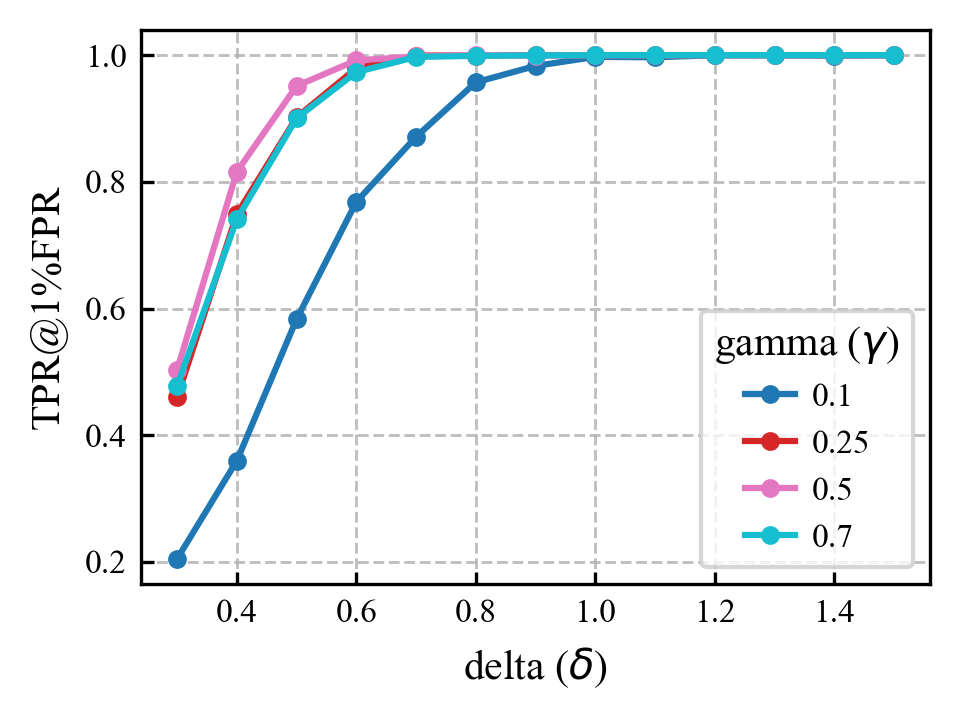

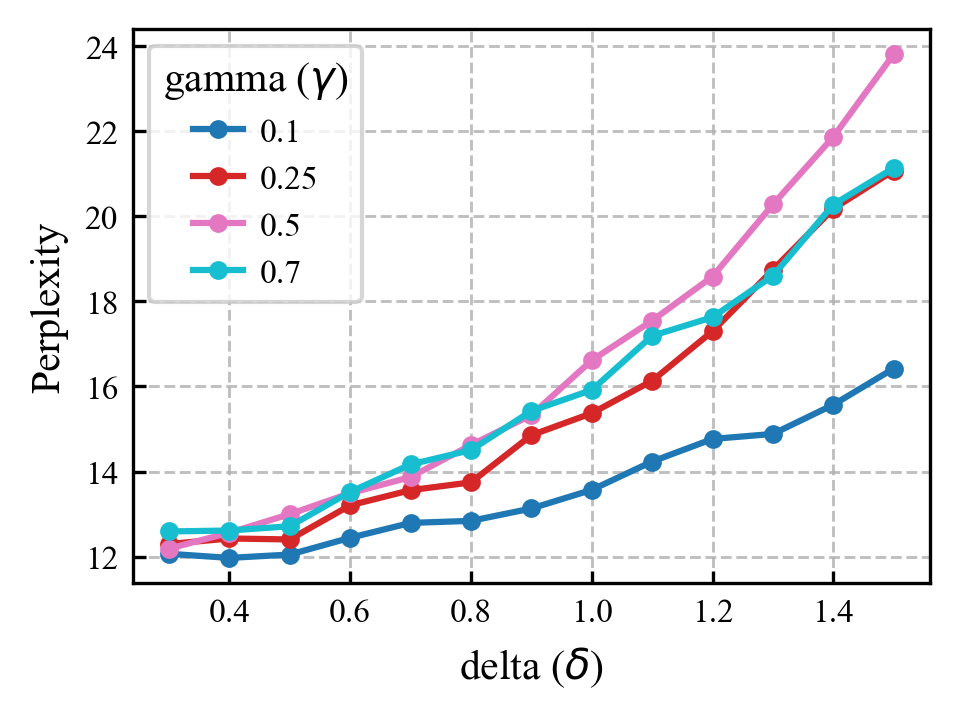

In [7]:
# Create a line plot of tpr_1_fpr vs delta for each gamma
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# Filter by model
# Optional: apply style if not done globally
plt.style.use("aaai.mplstyle")
data = grouped_df[grouped_df["config_id"].str.contains("watermark=mb") & (grouped_df["n_clusters"] == 235)]
data["gamma"] = data["gamma"].round(2)
data = data[data["gamma"].isin([0.1, 0.25, 0.5, 0.7])]
data = data[data["delta"] <= 1.5]

# Get unique gamma values and assign a distinct color to each
gammas = sorted(data["gamma"].unique())
colors = cm.get_cmap("tab10", len(gammas))

# ---------- Plot 1: TPR@1%FPR vs Delta ----------
fig, ax = plt.subplots(figsize=(3.3, 2.5))  # AAAI half-column width

for i, gamma in enumerate(gammas):
    subset = data[data["gamma"] == gamma]
    # Sort by delta
    subset = subset.sort_values(by="delta")

    ax.plot(subset["delta"], subset["tpr_1_fpr"], marker="o", markersize=3.5, label=f"{gamma}", color=colors(i))

ax.set_xlabel("delta ($\\delta$)")
ax.set_ylabel("TPR@1%FPR")
ax.legend(title="gamma ($\\gamma$)", loc="best", frameon=True)
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.8)

ax.tick_params(direction='in', length=3, width=0.8)
plt.tight_layout()
plt.savefig("tpr_vs_delta.pdf", bbox_inches="tight")
plt.show()

# ---------- Plot 2: Perplexity vs Delta ----------
fig, ax = plt.subplots(figsize=(3.3, 2.5))

for i, gamma in enumerate(gammas):
    subset = data[data["gamma"] == gamma]
    # Sort by delta
    subset = subset.sort_values(by="delta")
    ax.plot(subset["delta"], subset["ppl_mean"], marker="o", markersize=3.5, label=f"{gamma}", color=colors(i))

ax.set_xlabel("delta ($\\delta$)")
ax.set_ylabel("Perplexity")
ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.8)

ax.legend(title="gamma ($\\gamma$)", loc="best", frameon=True)
ax.tick_params(direction='in', length=3, width=0.8)
plt.tight_layout()
plt.savefig("ppl_vs_delta.pdf", bbox_inches="tight")
plt.show()



/tmp/ipykernel_1212263/1310119054.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_data["gamma"] = mb_data["gamma"].round(2)
/tmp/ipykernel_1212263/1310119054.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("tab10", len(gammas))


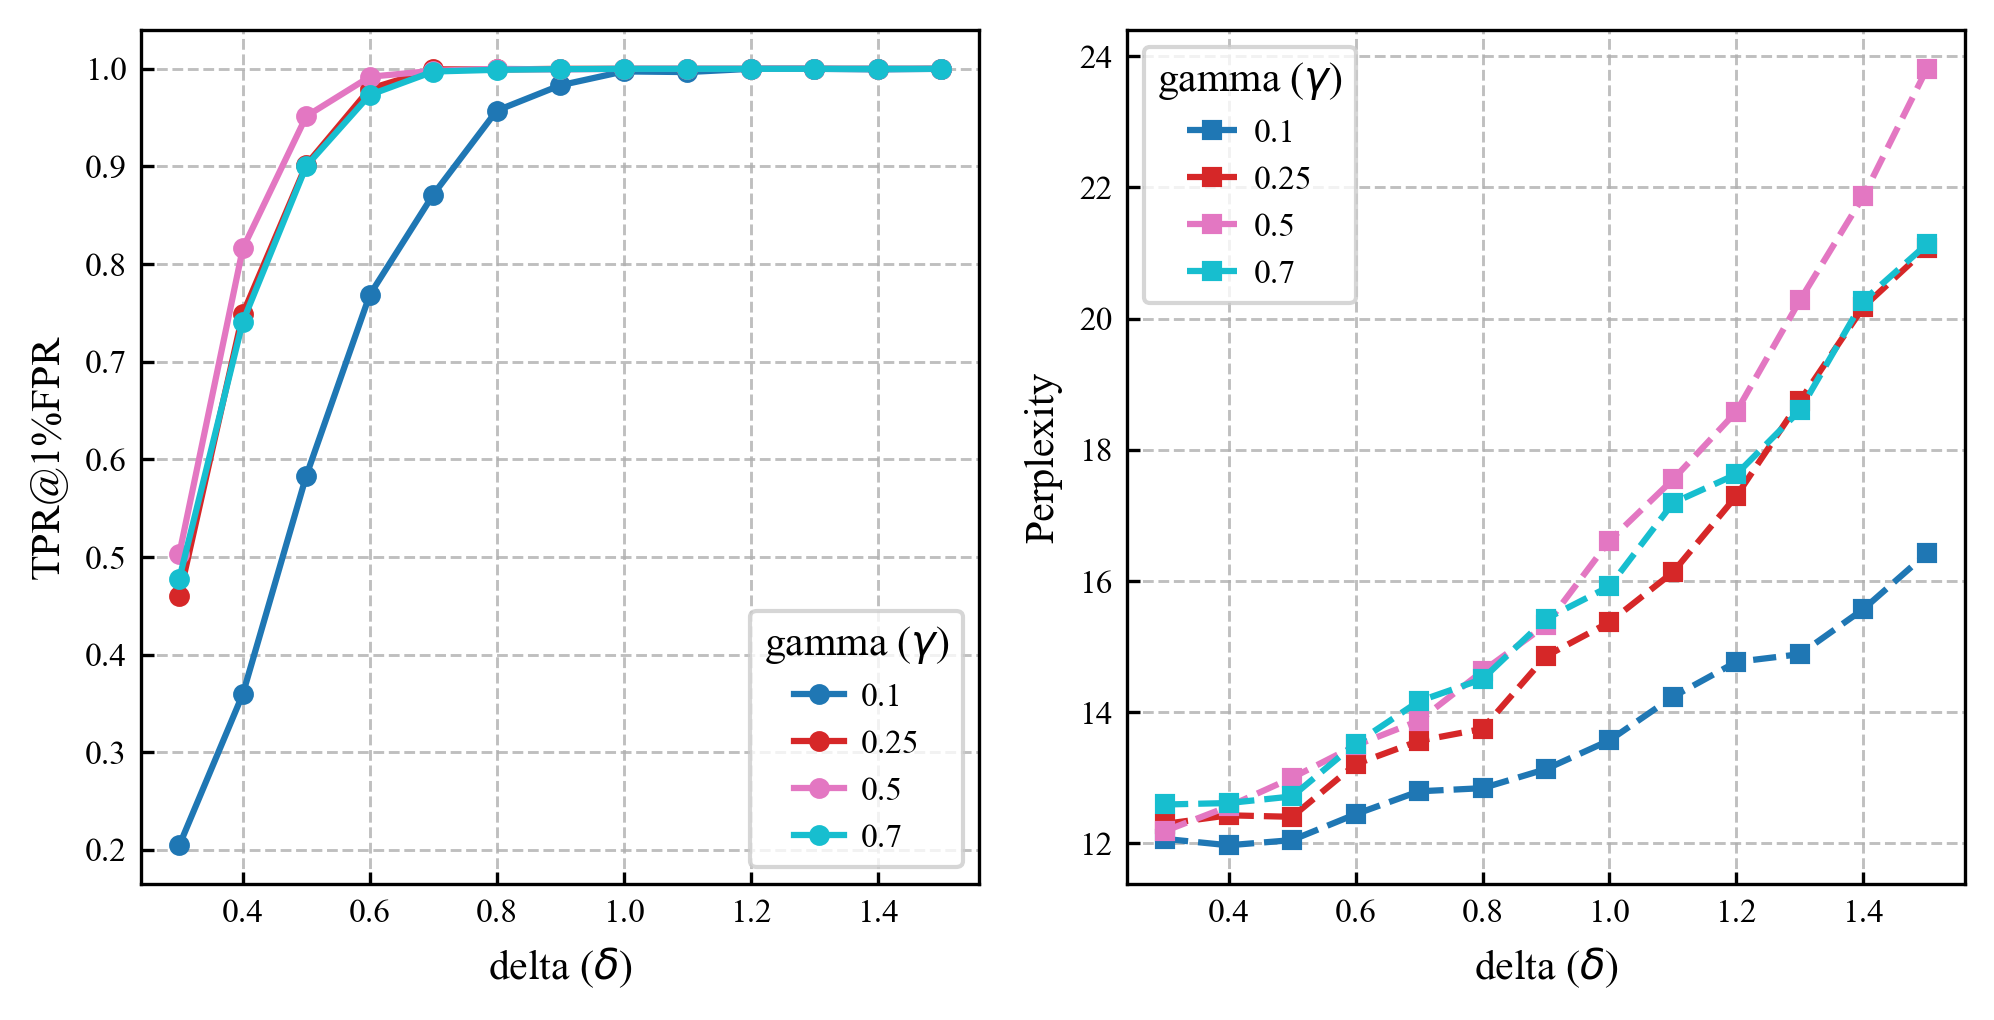

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Apply AAAI style
plt.style.use("aaai.mplstyle")
data = grouped_df   
# Filter and preprocess
mb_data = data[data["config_id"].str.contains("watermark=mb") & (data["n_clusters"] == 235)]
mb_data["gamma"] = mb_data["gamma"].round(2)
mb_data = mb_data[mb_data["gamma"].isin([0.1, 0.25, 0.5, 0.7])]

# Filter out delta values greater than 1.5
mb_data = mb_data[mb_data["delta"] <= 1.5]

# Gamma values and colormap
gammas = sorted(mb_data["gamma"].unique())
colors = cm.get_cmap("tab10", len(gammas))

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.75, 3.5), sharex=True)

for i, gamma in enumerate(gammas):
    subset = mb_data[mb_data["gamma"] == gamma].sort_values("delta")

    # TPR plot
    ax1.plot(subset["delta"], subset["tpr_1_fpr"], marker="o", markersize=4,
             label=f"{gamma}", color=colors(i), linestyle="-")

    # PPL plot
    ax2.plot(subset["delta"], subset["ppl_mean"], marker="s", markersize=4,
             label=f"{gamma}", color=colors(i), linestyle="--")

# Labels and ticks
ax1.set_xlabel("delta ($\\delta$)")
ax1.set_ylabel("TPR@1%FPR")
ax2.set_xlabel("delta ($\\delta$)")
ax2.set_ylabel("Perplexity")

for ax in (ax1, ax2):
    ax.tick_params(direction='in', length=3, width=0.8)
    ax.grid(True, linestyle='--', linewidth=0.7, alpha=0.8)
    ax.legend(title="gamma ($\\gamma$)", loc="best", frameon=True)

# Finalize and export
plt.tight_layout()
plt.savefig("split_tpr_ppl_with_legends.pdf", bbox_inches="tight")
plt.show()

In [9]:
# Create a grid map with tpr_1_fpr as values and gamma and delta as coordinates
# Filter n_clusters to 786
filtered_data = data[data["n_clusters"] == 786]
grid_map = filtered_data.pivot_table(
    index="gamma",
    columns="delta",
    values="ppl_mean",
    aggfunc="mean"
)

# Filter delta values to [0.4, 0.5, 0.6, 0.7]
delta_values = [0.4, 0.5, 0.6]
grid_map = grid_map[delta_values]

# Display in a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.set(style="whitegrid", font_scale=1.3)
ax = sns.heatmap(
    grid_map,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn_r",  # Red for bad (high), green for good (low)
    cbar_kws={'label': 'Perplexity'},
    linewidths=0.5,
    linecolor='white',
    square=True,
    annot_kws={"size": 12}
)
ax.set_title("Perplexity by Gamma and Delta", fontsize=16, pad=16)
ax.set_xlabel("Delta", fontsize=14)
ax.set_ylabel("Gamma", fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()


grid_map = filtered_data.pivot_table(
    index="gamma",
    columns="delta",
    values="tpr_1_fpr",
    aggfunc="mean"
)

grid_map = grid_map[delta_values]

plt.figure(figsize=(8, 5))
sns.set(style="whitegrid", font_scale=1.3)
ax = sns.heatmap(
    grid_map,
    annot=True,
    fmt=".2f",
    cmap="Blues",  # Red for bad (high), green for good (low)
    cbar_kws={'label': 'TPR@FPR=1%'},
    linewidths=0.5,
    linecolor='white',
    square=True,
    annot_kws={"size": 12}
)
ax.set_title("TPR@FPR=1% by Gamma and Delta", fontsize=16, pad=16)
ax.set_xlabel("Delta", fontsize=14)
ax.set_ylabel("Gamma", fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show()

KeyError: '[0.4] not in index'

In [ ]:
model = "Llama-3.1-8B"
model = "Mistral-7B-v0.3"
model = "Llama-2-7b-hf"

filtered_df = grouped_df[
    (grouped_df["model"] == model) &
    (grouped_df["dataset"] == "realnewslike") &
    (grouped_df["config_id"].str.contains("watermark=noise")) &
    (grouped_df["distribution"].isin(["gaussian", "symmetric_beta"]))
]

# Create combined column from distribution and version
filtered_df["tag"] = filtered_df["distribution"] + "_" + filtered_df["version"]

filtered_df

/tmp/ipykernel_3789602/1998098077.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["tag"] = filtered_df["distribution"] + "_" + filtered_df["version"]


,config_id,dataset,model,distribution,delta,version,auroc,best_f1_score,tpr_1_fpr,tpr_0.1_fpr,ppl_mean,ppl_median,mean_seq_rep_3,tag
0,watermark=noise_delta=0.0_distribution=gaussian,realnewslike,Llama-2-7b-hf,gaussian,0.00,base,0.500000,0.666667,0.010000,0.001000,12.116781,11.062500,0.028659,gaussian_base
1,watermark=noise_delta=0.0_distribution=gaussian,realnewslike,Llama-2-7b-hf,gaussian,0.00,v2,0.500000,0.666667,0.010000,0.001000,12.116781,11.062500,0.028659,gaussian_v2
4,watermark=noise_delta=0.0_distribution=symmetr...,realnewslike,Llama-2-7b-hf,symmetric_beta,0.00,base,0.500000,0.666667,0.010000,0.001000,12.116781,11.062500,0.028659,symmetric_beta_base
5,watermark=noise_delta=0.0_distribution=symmetr...,realnewslike,Llama-2-7b-hf,symmetric_beta,0.00,v2,0.500000,0.666667,0.010000,0.001000,12.116781,11.062500,0.028659,symmetric_beta_v2
10,watermark=noise_delta=0.15_distribution=gaussian,realnewslike,Llama-2-7b-hf,gaussian,0.15,base,0.782949,0.759983,0.166667,0.037733,12.279427,10.583333,0.030111,gaussian_base
11,watermark=noise_delta=0.15_distribution=gaussian,realnewslike,Llama-2-7b-hf,gaussian,0.15,v2,0.855803,0.786205,0.215333,0.031333,12.279427,10.583333,0.030111,gaussian_v2
16,watermark=noise_delta=0.15_distribution=symmet...,realnewslike,Llama-2-7b-hf,symmetric_beta,0.15,base,0.781403,0.753738,0.219875,0.046500,11.811854,10.312500,0.032246,symmetric_beta_base
17,watermark=noise_delta=0.15_distribution=symmet...,realnewslike,Llama-2-7b-hf,symmetric_beta,0.15,v2,0.732621,0.742745,0.176000,0.034000,11.766781,10.520833,0.030924,symmetric_beta_v2
24,watermark=noise_delta=0.25_distribution=gaussian,realnewslike,Llama-2-7b-hf,gaussian,0.25,base,0.930811,0.874613,0.457500,0.215667,12.378328,10.583333,0.028778,gaussian_base
25,watermark=noise_delta=0.25_distribution=gaussian,realnewslike,Llama-2-7b-hf,gaussian,0.25,v2,0.955383,0.890114,0.532667,0.180000,12.378328,10.583333,0.028778,gaussian_v2


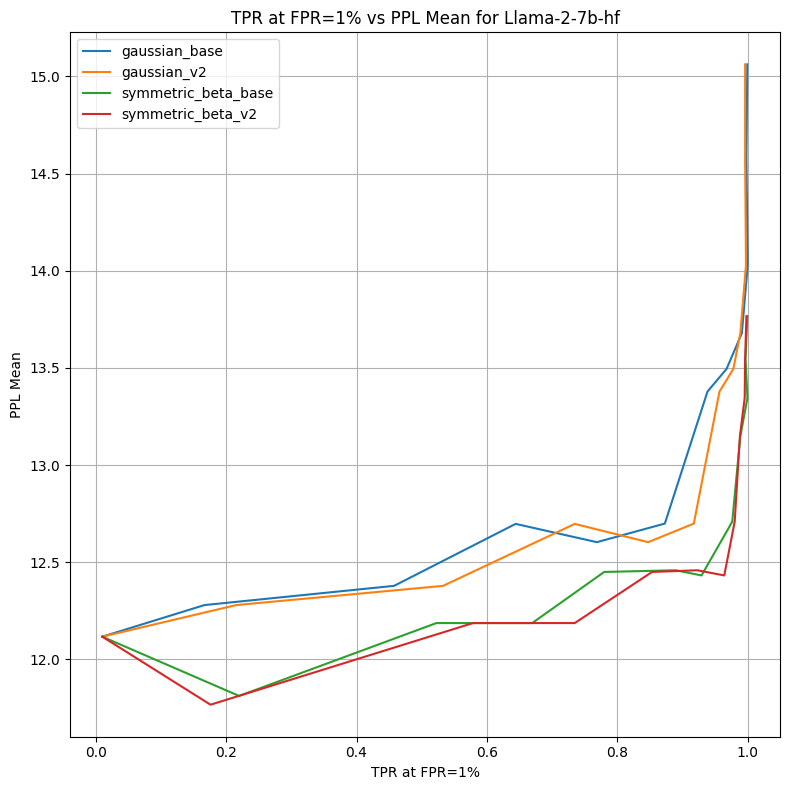

In [ ]:
import numpy as np
# For every distribution, plot tpr_1_fpr vs ppl_mean
# Sort by ppl_mean. Show all distributions in one plot for comparison
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
for distribution in filtered_df["tag"].unique():
    dist_df = filtered_df[filtered_df["tag"] == distribution]
    # Sort by delta
    dist_df = dist_df.sort_values(by="delta")

    # # Smooth the data
    # dist_df["ppl_mean"] = dist_df["ppl_mean"].rolling(window=1, min_periods=1).mean()
    # dist_df["tpr_1_fpr"] = dist_df["tpr_1_fpr"].rolling(window=1, min_periods=1).mean()

    plt.plot(
        dist_df["tpr_1_fpr"],
        dist_df["ppl_mean"],
        label=f"{distribution}"
    )
plt.ylabel("PPL Mean")
plt.xlabel("TPR at FPR=1%")
plt.title(f"TPR at FPR=1% vs PPL Mean for {model}")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
# Only keep rows with model=Llama-2-7b-hf and dataset=realnewslike and config_id containing "watermark=mb3"
filtered_df = grouped_df[
    (grouped_df["model"] == "Llama-2-7b-hf") &
    (grouped_df["dataset"] == "realnewslike") &
    (grouped_df["config_id"].str.contains("watermark=noise"))
]

# Select columns config_id, auroc, best_f1_score, tpr_1_fpr, tpr_0.1_fpr, mean_seq_rep_3, ppl_mean
filtered_df = filtered_df[[
    "config_id", "auroc", "best_f1_score", "tpr_1_fpr",
    "tpr_0.1_fpr", "mean_seq_rep_3", "ppl_mean"
]]

filtered_df

,config_id,auroc,best_f1_score,tpr_1_fpr,tpr_0.1_fpr,mean_seq_rep_3,ppl_mean
0,watermark=noise_delta=0.0_distribution=gaussian,0.500000,0.666667,0.010000,0.001000,0.028659,12.116781
3,watermark=noise_delta=0.0_distribution=symmetr...,0.500000,0.666667,0.010000,0.001000,0.028659,12.116781
6,watermark=noise_delta=0.0_distribution=uniform,0.500000,0.666667,0.010000,0.001000,0.028659,12.116781
9,watermark=noise_delta=0.15_distribution=gaussian,0.782949,0.759983,0.166667,0.037733,0.030111,12.279427
12,watermark=noise_delta=0.15_distribution=symmet...,0.781403,0.753738,0.219875,0.046500,0.032246,11.811854
15,watermark=noise_delta=0.15_distribution=trunca...,0.728644,0.730134,0.114444,0.012444,0.029967,12.010646
16,watermark=noise_delta=0.15_distribution=uniform,0.755005,0.743180,0.113781,0.020071,0.028730,11.985750
19,watermark=noise_delta=0.25_distribution=gaussian,0.930811,0.874613,0.457500,0.215667,0.028778,12.378328
22,watermark=noise_delta=0.25_distribution=symmet...,0.924527,0.861624,0.522471,0.205756,0.031515,12.186865
25,watermark=noise_delta=0.25_distribution=trunca...,0.897815,0.841011,0.345815,0.105444,0.027946,12.313218
